In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
import matplotlib .pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet

# Project-1
- TL모델 : Mobilenet

In [4]:
# 경로 설정
root_dir = "/content"
data_root_dir = os.path.join(root_dir, "brain_tumor")
train_root_dir = os.path.join(data_root_dir, "Training")
test_root_dir = os.path.join(data_root_dir, "Testing")
val_root_dir = os.path.join(data_root_dir, "Validaion")

In [5]:
# 데이터 셋 가져오기
from google.colab import drive
drive.mount("/content/drive")

shutil.copy(os.path.join("/content/drive/MyDrive", "brain_tumor.zip"), root_dir)

if os.path.exists(data_root_dir):
  shutil.rmtree(data_root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "brain_tumor.zip")) as target_file:
  target_file.extractall(root_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# train data 갯수
train_label_name_list = os.listdir(train_root_dir)

for train_label_name in train_label_name_list:
  print("label 명 : ", train_label_name, " / ", len(os.listdir(os.path.join(train_root_dir, train_label_name))))

print("===================================================================================")
# test data 갯수
test_label_name_list = os.listdir(test_root_dir)

for test_label_name in test_label_name_list:
  print("label 명 : ", test_label_name, " / ", len(os.listdir(os.path.join(test_root_dir, test_label_name))))

label 명 :  pituitary_tumor  /  827
label 명 :  glioma_tumor  /  826
label 명 :  no_tumor  /  395
label 명 :  meningioma_tumor  /  822
label 명 :  pituitary_tumor  /  74
label 명 :  glioma_tumor  /  100
label 명 :  no_tumor  /  105
label 명 :  meningioma_tumor  /  115


In [7]:
# train의 20% validatioin으로 분류
train_file_list = os.listdir(train_root_dir)
if not os.path.exists(val_root_dir):
  os.mkdir(val_root_dir)

for train_file in train_file_list:
  src = os.path.join(train_root_dir, train_file)
  dst = os.path.join(val_root_dir, train_file)

  train_file_name_list = os.listdir(src)

  move_ratio = 0.2
  split_num = int(len(train_file_name_list)*move_ratio)
  move_file_list = train_file_name_list[0:split_num]
  os.mkdir(os.path.join(val_root_dir, train_file))

  move_num = 0
  for move_file in move_file_list:
    shutil.move(os.path.join(src, move_file),
                os.path.join(dst, move_file))
    move_num += 1
  print("total move num : ", move_num)

total move num :  165
total move num :  165
total move num :  79
total move num :  164


In [8]:
# image shape 설정
img_width = 224
img_height = 224

In [9]:
# ImageDataGenerator 이용 데이터 불러오기
train_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_gen = train_data_gen.flow_from_directory(directory=train_root_dir,
                                               batch_size = 32,
                                               target_size = (img_height, img_width),
                                               class_mode = "sparse")
test_gen = test_data_gen.flow_from_directory(directory=test_root_dir,
                                               batch_size = 32,
                                               target_size = (img_height, img_width),
                                               class_mode = "sparse")
val_gen = val_data_gen.flow_from_directory(directory=val_root_dir,
                                               batch_size = 32,
                                               target_size = (img_height, img_width),
                                               class_mode = "sparse")

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [10]:
print(train_gen.class_indices)
print(test_gen.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [11]:
# 32장 이미지 미리보기
img, label = train_gen.next()
print(img.shape, label.shape)

(32, 224, 224, 3) (32,)


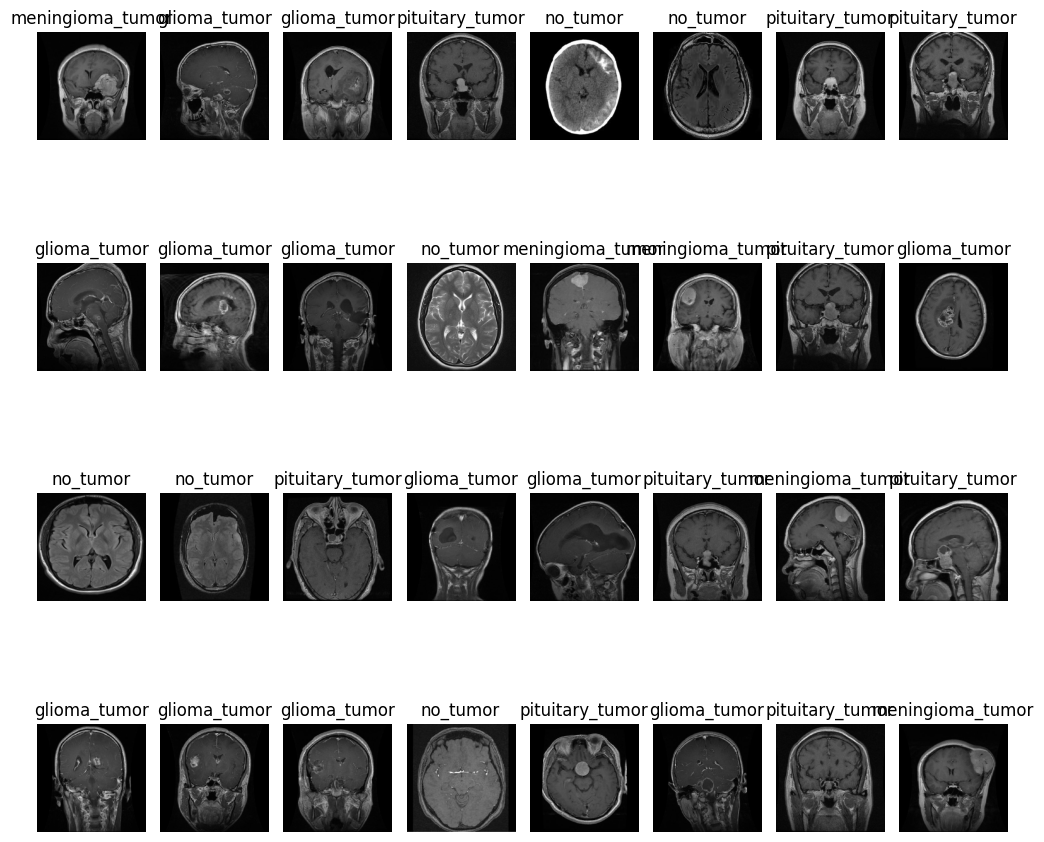

In [12]:
plt.figure(figsize = (10, 10))
class_dict = {0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}

for i in range(len(label)):
  plt.subplot(4, 8, i+1)
  plt.axis("off")
  plt.title(class_dict[label[i]])
  plt.imshow(img[i])
plt.tight_layout()

In [13]:
# Mobilenet 모델 구축(Fine_Tuning)
base_model = MobileNet(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))
base_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [14]:
# fine_tuning(normal)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(1e-5), metrics = "acc")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 4)                 200708    
                                                                 
Total params: 3,429,572
Trainable params: 3,407,684
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

Epoch 1/20
72/72 [==============================] - 49s 278ms/step - loss: 1.1717 - acc: 0.5964 - val_loss: 1.0560 - val_acc: 0.6283
Epoch 2/20
72/72 [==============================] - 16s 224ms/step - loss: 0.3958 - acc: 0.8598 - val_loss: 0.9005 - val_acc: 0.6946
Epoch 3/20
72/72 [==============================] - 16s 223ms/step - loss: 0.2119 - acc: 0.9290 - val_loss: 0.8790 - val_acc: 0.7033
Epoch 4/20
72/72 [==============================] - 16s 226ms/step - loss: 0.1240 - acc: 0.9656 - val_loss: 0.7604 - val_acc: 0.7243
Epoch 5/20
72/72 [==============================] - 17s 234ms/step - loss: 0.0781 - acc: 0.9865 - val_loss: 0.6589 - val_acc: 0.7644
Epoch 6/20
72/72 [==============================] - 18s 257ms/step - loss: 0.0518 - acc: 0.9926 - val_loss: 0.5554 - val_acc: 0.7958
Epoch 7/20
72/72 [==============================] - 16s 219ms/step - loss: 0.0363 - acc: 0.9978 - val_loss: 0.5096 - val_acc: 0.8168
Epoch 8/20
72/72 [==============================] - 16s 222ms/step - 

In [ ]:
# evaluate
model.evaluate(test_gen)

13/13 [==============================] - 2s 170ms/step - loss: 1.7956 - acc: 0.7208


[1.7956156730651855, 0.720812201499939]

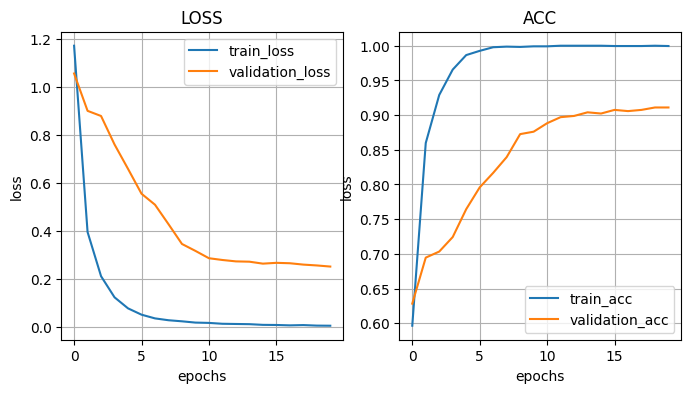

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

### P1 - Hidden layer 3개(node : 128), dropout 0.25

In [ ]:
# Mobilenet 모델 구축(Fine_Tuning)
base_model = MobileNet(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning(hidden 3(node : 128), dropout 0.25)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(1e-5), metrics = "acc")
model.summary()

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               6422656   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

[0.9578800797462463, 0.7563451528549194]

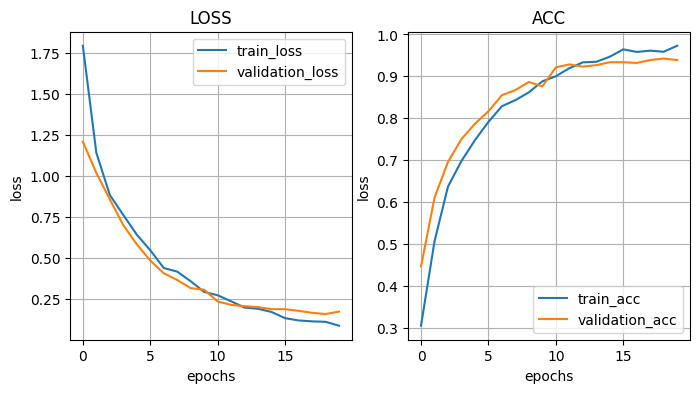

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

### P1 - Hidden layer 3개(node : 256), dropout 0.25 / callback : Earlystopping

In [ ]:
# Mobilenet 모델 구축(Fine_Tuning)
base_model = MobileNet(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning(hidden 3(node : 128), dropout 0.25)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(1e-5), metrics = "acc")
model.summary()

tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen,
                   callbacks = tf_stop)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6422656   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                      

[1.1783924102783203, 0.7335025668144226]

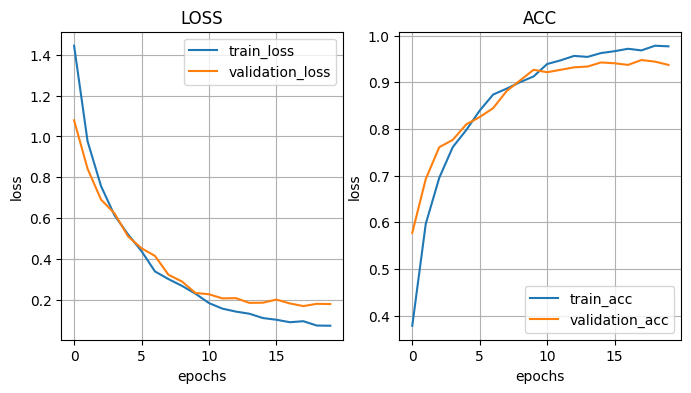

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

### P1 - Train, test 파일 Shuffle 후 재분배
- Hidden layer 3개(node : 128), dropout 0.25 / callback : Earlystopping

In [15]:
test_label_name_list = os.listdir(test_root_dir)
print(test_label_name_list)

['pituitary_tumor', 'glioma_tumor', 'no_tumor', 'meningioma_tumor']


In [16]:
# Testing, validation --> Training
for label_name in test_label_name_list:
    test_path = os.path.join(test_root_dir, label_name)
    val_path = os.path.join(val_root_dir, label_name)
    test_file_list = os.listdir(test_path)
    val_file_list = os.listdir(val_path)

    train_path = os.path.join(train_root_dir, label_name)

    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num += 1

    move_num = 0
    for val_file in val_file_list:
        shutil.move(os.path.join(val_path, val_file), os.path.join(train_path, val_file))
        move_num += 1

    print("Testing", str(move_num) + " => Training :" + label_name)
    print("------------------------------------------------------")
    print("Validation", str(move_num) + " => Training :" + label_name)

Testing 165 => Training :pituitary_tumor
------------------------------------------------------
Validation 165 => Training :pituitary_tumor
Testing 165 => Training :glioma_tumor
------------------------------------------------------
Validation 165 => Training :glioma_tumor
Testing 79 => Training :no_tumor
------------------------------------------------------
Validation 79 => Training :no_tumor
Testing 164 => Training :meningioma_tumor
------------------------------------------------------
Validation 164 => Training :meningioma_tumor


In [17]:
## Traing 갯수 확인
train_label_name_list = os.listdir(train_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_root_dir, label_name))))

train label : pituitary_tumor  => 901
train label : glioma_tumor  => 926
train label : no_tumor  => 396
train label : meningioma_tumor  => 937


In [18]:
### shuffle 후 다시 Testing -> Traing 이동
move_ratio = 0.2

label_name_list = os.listdir(train_root_dir)

for label_name in label_name_list:
    src = os.path.join(train_root_dir, label_name)
    dst_test = os.path.join(test_root_dir, label_name)
    dst_val = os.path.join(val_root_dir, label_name)

    train_data_file_list = os.listdir(src)


    print("===========================================")
    print("total [%s] data file nums => [%s]"%(label_name,
                                               len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)

    split_num = int(move_ratio*len(train_data_file_list))
    print("split nums = ", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst_test, test_data_file))
        move_num += 1

    print("total move num => ", move_num)
    print("=========================================")

total [pituitary_tumor] data file nums => [901]
split nums =  180
total move num =>  180
total [glioma_tumor] data file nums => [926]
split nums =  185
total move num =>  185
total [no_tumor] data file nums => [396]
split nums =  79
total move num =>  79
total [meningioma_tumor] data file nums => [937]
split nums =  187
total move num =>  187


In [19]:
### shuffle 후 다시 Validation -> Training 이동
move_ratio = 0.2

label_name_list = os.listdir(train_root_dir)

for label_name in label_name_list:
    src = os.path.join(train_root_dir, label_name)
    dst_val = os.path.join(val_root_dir, label_name)

    train_data_file_list = os.listdir(src)


    print("===========================================")
    print("total [%s] data file nums => [%s]"%(label_name,
                                               len(train_data_file_list)))

    split_num = int(move_ratio*len(train_data_file_list))
    print("split nums = ", split_num)

    val_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for val_data_file in val_data_file_list:
        shutil.move(os.path.join(src, val_data_file),
                   os.path.join(dst_val, val_data_file))
        move_num += 1

    print("total move num => ", move_num)
    print("=========================================")


total [pituitary_tumor] data file nums => [721]
split nums =  144
total move num =>  144
total [glioma_tumor] data file nums => [741]
split nums =  148
total move num =>  148
total [no_tumor] data file nums => [317]
split nums =  63
total move num =>  63
total [meningioma_tumor] data file nums => [750]
split nums =  150
total move num =>  150


In [20]:
# ImageDataGenerator 이용 데이터 불러오기
train_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_gen = train_data_gen.flow_from_directory(directory=train_root_dir,
                                               batch_size = 32,
                                               target_size = (img_height, img_width),
                                               class_mode = "sparse")
test_gen = test_data_gen.flow_from_directory(directory=test_root_dir,
                                               batch_size = 32,
                                               target_size = (img_height, img_width),
                                               class_mode = "sparse")
val_gen = val_data_gen.flow_from_directory(directory=val_root_dir,
                                               batch_size = 32,
                                               target_size = (img_height, img_width),
                                               class_mode = "sparse")

Found 2024 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
Found 505 images belonging to 4 classes.


In [21]:
# Mobilenet 모델 구축(Fine_Tuning)
base_model = MobileNet(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning(hidden 3(node : 128), dropout 0.25)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(1e-5), metrics = "acc")
model.summary()

tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen,
                   callbacks = tf_stop)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               6422656   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

[0.2712135910987854, 0.9207606911659241]

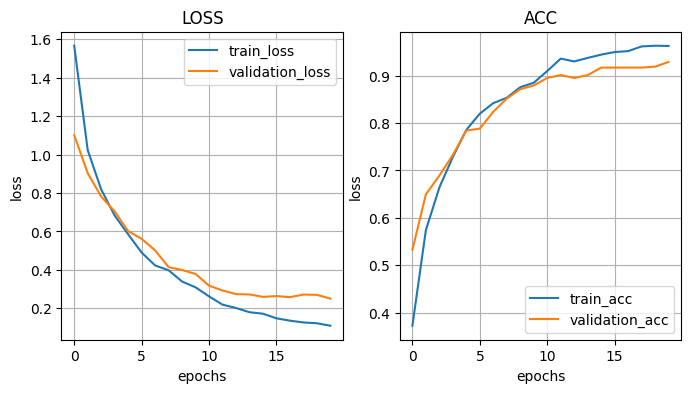

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

### P1 - Shuffle된 Train, test 파일
- Hidden layer 3개(node : 128), dropout 0.3 / callback : Earlystopping

In [ ]:
# Mobilenet 모델 구축(Fine_Tuning)
base_model = MobileNet(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning(hidden 3(node : 128), dropout 0.25)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(1e-5), metrics = "acc")
model.summary()

tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen,
                   callbacks = tf_stop)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 50176)             0         
                                                                 
 dense_17 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                      

[0.2880900502204895, 0.9049128293991089]

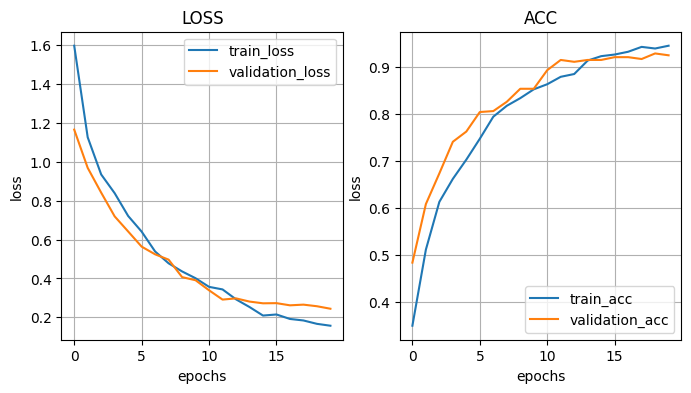

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

# Project-2
- TL모델 : Xception(Shuffle 한 Dataset)

In [ ]:
# Xception 모델 구축(Fine_Tuning)
base_model = Xception(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(1e-5), metrics = "acc")
model.summary()

tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen,
                   callbacks = tf_stop)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dense_22 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 128)              

[0.5103765726089478, 0.8763867020606995]

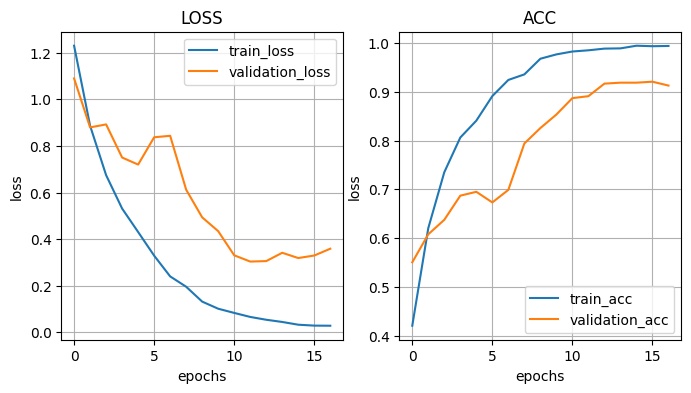

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

### P2 - Shuffle된 Train, test 파일
- Hidden layer 3개(node : 128), dropout 0.3 / callback : Earlystopping

In [ ]:
# Xception 모델 구축(Fine_Tuning)
base_model = Xception(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(2e-5), metrics = "acc")
model.summary()

#tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_9 (Flatten)         (None, 100352)            0         
                                                                 
 dense_30 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 128)              

[0.6588048934936523, 0.8985736966133118]

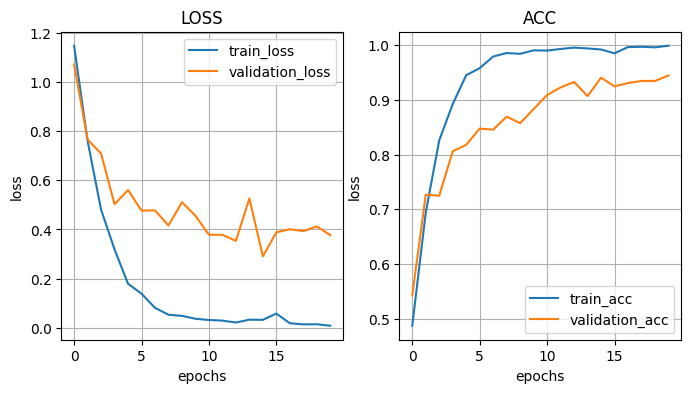

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

### P2 - Shuffle된 Train, test 파일
- Hidden layer 3개(node : 128), dropout 0.5 / callback : Earlystopping

In [32]:
# Xception 모델 구축(Fine_Tuning)
base_model = Xception(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(2e-5), metrics = "acc")
model.summary()

tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen,
                   callbacks = tf_stop)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 dense_32 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 128)              

[0.4917789697647095, 0.9017432928085327]

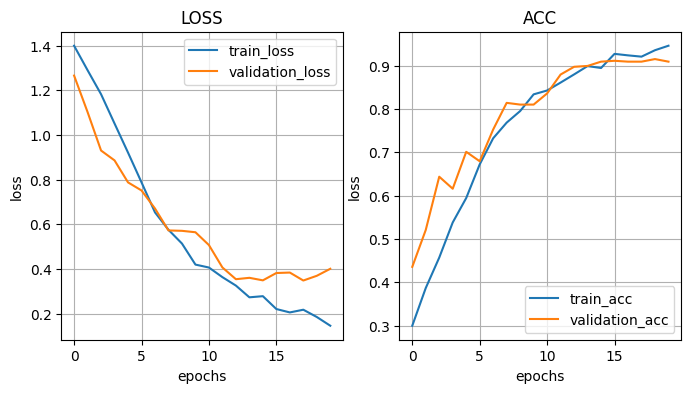

In [33]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

# Project-3
- TL모델 : Resnet(Shuffle 한 Dataset)

In [ ]:
# Xception 모델 구축(Fine_Tuning)
base_model = ResNet50(weights = "imagenet", include_top = False,
                       input_shape = (img_width, img_height, 3))

# fine_tuning
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(4, activation = "softmax"))
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = Adam(2e-5), metrics = "acc")
model.summary()

tf_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5)

# fitting
start_time = datetime.now()

result = model.fit(train_gen, epochs = 20, validation_data = val_gen,
                   callbacks = tf_stop)

end_time = datetime.now()
print("소요시간 : ", end_time - start_time)

# evaluate
model.evaluate(test_gen)

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 100352)            0         
                                                                 
 dense_36 (Dense)            (None, 128)               12845184  
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                       

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")